In [1]:
!pip install transformers

In [148]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv('/content/augmented_data (1) - Copy.csv')
df.head()

,Questions,Blooms Taxonomy
0,Given is an array after the first partition of...,remember
1,How many steps are required to solve Tower of ...,remember
2,How many comparisons are required to find elem...,remember
3,"Given an array A[-3:4, 6:10], Find the address...",remember
4,"Consider the following list of 10 numbers: 35,...","apply , remember"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3042 entries, 0 to 3041
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Questions        3042 non-null   object
 1   Blooms Taxonomy  3042 non-null   object
dtypes: object(2)
memory usage: 47.7+ KB


In [5]:
# Convert 'Understanding' to 'Understand' in 'Column_with_Understanding'
df['Blooms Taxonomy'] = df['Blooms Taxonomy'].replace('Understanding', 'understand')

print(df['Blooms Taxonomy'])

0               remember
1               remember
2               remember
3               remember
4       apply , remember
              ...       
3037            Remember
3038            Remember
3039            Remember
3040            Remember
3041            Remember
Name: Blooms Taxonomy, Length: 3042, dtype: object


In [6]:
word_to_encoding = {
    'remember': 0,
    'understand': 1,
    'apply': 2,
    'analyze': 3,
    'evaluate': 4,
    'create': 5
}

def map_words_to_encoding(words):
    words = [word.strip().lower() for word in words.split(',')]
    encoding_values = [word_to_encoding[word] for word in words if word in word_to_encoding]
    return max(encoding_values) if encoding_values else 0


df['encoded_values'] = df['Blooms Taxonomy'].apply(map_words_to_encoding)

print(df)

                                              Questions   Blooms Taxonomy  \
0     Given is an array after the first partition of...          remember   
1     How many steps are required to solve Tower of ...          remember   
2     How many comparisons are required to find elem...          remember   
3     Given an array A[-3:4, 6:10], Find the address...          remember   
4     Consider the following list of 10 numbers: 35,...  apply , remember   
...                                                 ...               ...   
3037  In Express.js, how would you chain multiple mi...          Remember   
3038  In the MVC pattern, what does the "Model" repr...          Remember   
3039  Which method is used to create a resolved prom...          Remember   
3040  How can you rename an exported function during...          Remember   
3041  How do you define a Sequelize model named "Use...          Remember   

      encoded_values  
0                  0  
1                  0  
2     

### **Data Preparation**

In [7]:
df['encoded_values'] = df['encoded_values'].astype(int)

In [8]:
df['encoded_values'].value_counts()

1    652
0    578
5    518
3    490
2    416
4    388
Name: encoded_values, dtype: int64

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
token = tokenizer.encode_plus(
    df['Questions'].iloc[0],
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)

In [11]:
token.input_ids

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101, 10470,  1110,  1126,  9245,  1170,  1103,  1148, 16416,
         1104,  3613, 21484,  1204,   131,   124,   117,   121,   117,
          123,   117,   125,   117,  1275,   117,   129,   117,   128,
          117,   127,   117,   130,   119,  5979,  1104,  1103,  5290,
         1180,  1129,  1103,   185, 15435,  1204,   136,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [12]:
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [13]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['Questions'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [14]:

X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [15]:

labels = np.zeros((len(df), 6))
labels.shape

(3042, 6)

In [16]:
labels[np.arange(len(df)), df['encoded_values'].values] = 1 # one-hot encoded target tensor

In [17]:
labels

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [18]:
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [19]:
def qualityDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [20]:
dataset = dataset.map(qualityDatasetMapFunction) # converting to required format for tensorflow dataset

In [21]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [22]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [35]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 6), dtype=tf.float64, name=None))>

In [24]:

p = 0.8
train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

In [25]:
train_size

152

In [26]:

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [49]:
tmp = []
for i, j in train_dataset:
  # print(j)
  tmp.append(j[0])
print(len(tmp)*16)

2432


In [48]:
tmp = []
for i, j in val_dataset:
  # print(j)
  tmp.append(j[0])
print(len(tmp)*16)

608


In [79]:


# tmp = []
# for i, j in val_dataset:
#   print(len(i), type(i))
#   print(len(i["input_ids"]))
#   for i1, i2 in i:
#     print(i1, i2)
#     break
#   # print(len(i), len(j))
#   # tmp.append(j[0])
#   break
# print(len(tmp)*16)

2 <class 'dict'>
16


ValueError: too many values to unpack (expected 2)

### **Model**

In [28]:
from transformers import TFBertModel

In [29]:
model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [30]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(6, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

blooms_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
blooms_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                                       

In [31]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')


In [32]:
blooms_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [33]:
hist = blooms_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30
)

Epoch 1/30
152/152 [==============================] - 153s 846ms/step - loss: 1.4181 - accuracy: 0.4161 - val_loss: 0.9820 - val_accuracy: 0.6464
Epoch 2/30
152/152 [==============================] - 132s 870ms/step - loss: 0.8927 - accuracy: 0.6665 - val_loss: 0.6184 - val_accuracy: 0.7664
Epoch 3/30
152/152 [==============================] - 135s 888ms/step - loss: 0.6439 - accuracy: 0.7656 - val_loss: 0.4194 - val_accuracy: 0.8701
Epoch 4/30
 91/152 [================>.............] - ETA: 49s - loss: 0.4528 - accuracy: 0.8413

KeyboardInterrupt: 

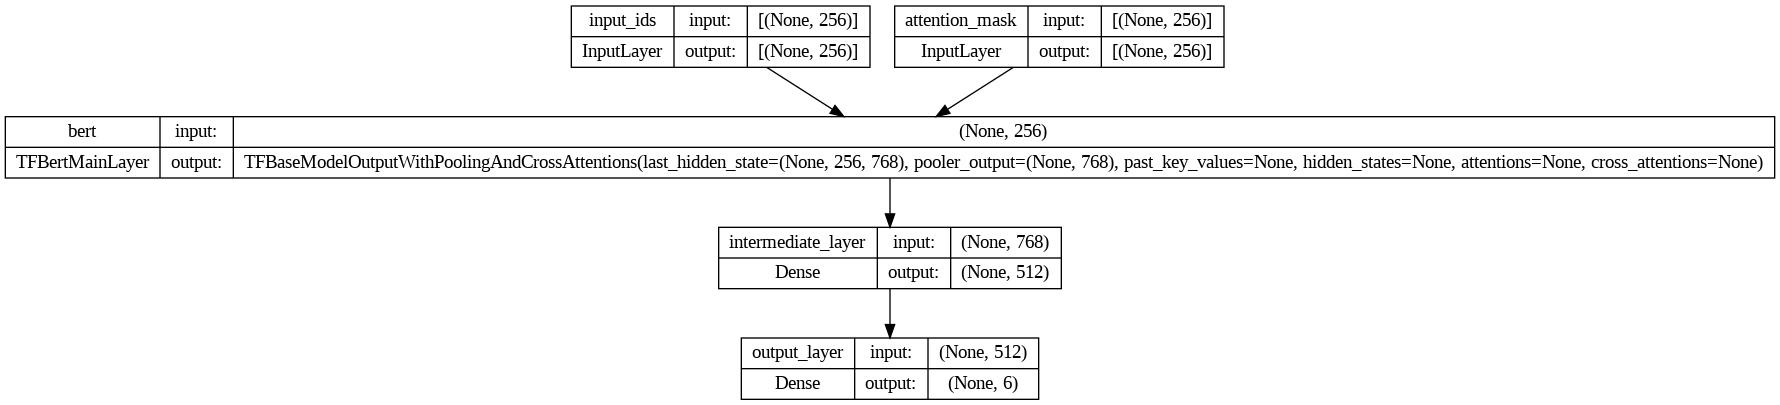

In [50]:
from tensorflow.keras.utils import plot_model
plot_model(blooms_model, to_file='blooms_model.png', show_shapes=True, show_layer_names=True)

In [51]:
blooms_model.save('blooms_model')

In [52]:
from tensorflow.keras.models import load_model

blooms_model.save('/content/saved_models/blooms_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
# from tensorflow.keras.models import load_model

# blooms_model.save('/content/drive/MyDrive/blooms_model.h5')

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
blooms_model.evaluate(val_dataset)

38/38 [==============================] - 10s 261ms/step - loss: 0.2967 - accuracy: 0.8964


[0.2967386245727539, 0.8963815569877625]

### **Prediction**

In [128]:
blooms_model = tf.keras.models.load_model('/content/saved_models/blooms_model.h5')

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=['remember', 'understand', 'apply', 'analyze', 'evaluate','create']):
    probs = model.predict(processed_data)[0]
    # print(probs)
    return classes[np.argmax(probs)], one_hot_encode(probs, 6)

In [59]:
def one_hot_encode(arr, num_classes):
    # Find the index of the maximum value in the array
    max_index = np.argmax(arr)

    # Create a new array to hold the one-hot encoded values
    one_hot_encoded = np.zeros(num_classes)

    # Set the highest value to 1
    one_hot_encoded[max_index] = 1

    return one_hot_encoded.astype(int)

In [60]:
input_text = input('Enter Question here: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(blooms_model, processed_data=processed_data)

print(f"Predicted blooms level: {result}")

Enter Question here: jbjn
1/1 [==============================] - 3s 3s/step
[0.14208242 0.10225429 0.07378475 0.22575794 0.42184928 0.03427137]
Predicted blooms level: ('evaluate', array([0, 0, 0, 0, 1, 0]))


In [61]:
true_labels = val_dataset

In [62]:
true_labels

<_SkipDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 6), dtype=tf.float64, name=None))>

In [94]:
new_labels = []
for i, j in val_dataset:
  for k in j:
    new_labels.append(k)

print(len(new_labels))

608


In [89]:
new_labels[0]

<tf.Tensor: shape=(6,), dtype=float64, numpy=array([0., 0., 0., 0., 1., 0.])>

In [88]:
new_labels[0].numpy()

array([0., 0., 0., 0., 1., 0.])

In [107]:
prepare_data(input_text, tokenizer)

{'input_ids': <tf.Tensor: shape=(1, 256), dtype=float64, numpy=
 array([[  101.,   179.,  1830., 22923.,   102.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,    

In [115]:
new_input_ids = []
new_attention_mask = []
new_labels = []
for i, j in val_dataset:

  for q in i["input_ids"]:
    new_input_ids.append(q.numpy().astype(int))

  for a_m in i["attention_mask"]:
    new_attention_mask.append(a_m.numpy().astype(int))

  for k in j:
    new_labels.append(k.numpy())

print(len(new_input_ids), len(new_attention_mask), len(new_labels))

608 608 608


In [ ]:
# np.array([new_input_ids[0], new_attention_mask[0]])

In [ ]:
# {'input_ids': tf.cast(new_input_ids[0], tf.float64), 'attention_mask': tf.cast(new_attention_mask[0], tf.float64)}

In [124]:
{'input_ids': tf.cast(new_input_ids[0].reshape(1, -1), tf.float64), 'attention_mask': tf.cast(new_attention_mask[0].reshape(1, -1), tf.float64)}

{'input_ids': <tf.Tensor: shape=(1, 256), dtype=float64, numpy=
 array([[  101., 25515.,   122., 20660., 21774.,  1105.,   125., 17909.,
          4304., 14500.,  1132., 16416.,  1174.,  1154.,  2724.,  2428.,
          2064.,  5511.,  1105.,  1937.,  2060.,  1110.,   123.,  2064.,
           119.,   113.,  5322.,   131., 25515., 14500.,  1112.,  1937.,
          4134.,  1895.,  1136.,  1118.,  1566.,  4134.,  1895.,   119.,
           114.,   102.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,    

In [125]:
make_prediction(blooms_model, {'input_ids': new_input_ids[0].reshape(1, -1), 'attention_mask': new_attention_mask[0].reshape(1, -1)})

1/1 [==============================] - 4s 4s/step
[0.01508547 0.01309357 0.14963473 0.53516155 0.27703556 0.00998907]


('analyze', array([0, 0, 0, 1, 0, 0]))

In [139]:
predictions = []

for i in range(5):
  predictions.append(make_prediction(blooms_model, {'input_ids': new_input_ids[i].reshape(1, -1), 'attention_mask': new_attention_mask[i].reshape(1, -1)})[1])

1/1 [==============================] - 0s 140ms/step


In [140]:
predictions

[array([0, 0, 0, 1, 0, 0]),
 array([1, 0, 0, 0, 0, 0]),
 array([0, 1, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 1, 0]),
 array([1, 0, 0, 0, 0, 0])]

In [143]:
np.argmax(predictions)

3

In [142]:
np.argmax(predictions[0])

3

In [146]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, top_k_accuracy_score, confusion_matrix
import numpy as np

# Assuming you already have the trained model and validation data generator (val_generator) from the previous code

# Evaluate the model on the validation set
predictions = []

for i in range(len(new_labels)):
  predictions.append(make_prediction(blooms_model, {'input_ids': new_input_ids[i].reshape(1, -1), 'attention_mask': new_attention_mask[i].reshape(1, -1)})[1])

# Convert predictions to class labels
# predicted_labels = np.argmax(predictions)

# Convert true labels to class labels
# true_labels = val_dataset.classes

predicted_labels = []
true_labels = []
for i in range(len(new_labels)):
  predicted_labels.append(np.argmax(predictions[i]))
  true_labels.append(np.argmax(new_labels[i]))

# Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate recall, F1 score, and classification report
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)
classification_rep = classification_report(true_labels, predicted_labels)

# Print the metrics
print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(conf_matrix)
print('Classification Report:')
print(classification_rep)

1/1 [==============================] - 0s 81ms/step
Overall Accuracy: 89.47%
Recall: 89.47%
F1 Score: 89.45%
[[114  10   0   0   0   0]
 [ 12 118   2   6   2   0]
 [  1   2  69  12   0   2]
 [  0   1   2  74   5   2]
 [  0   0   1   2  64   0]
 [  1   1   0   0   0 105]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       124
           1       0.89      0.84      0.87       140
           2       0.93      0.80      0.86        86
           3       0.79      0.88      0.83        84
           4       0.90      0.96      0.93        67
           5       0.96      0.98      0.97       107

    accuracy                           0.89       608
   macro avg       0.89      0.90      0.89       608
weighted avg       0.90      0.89      0.89       608



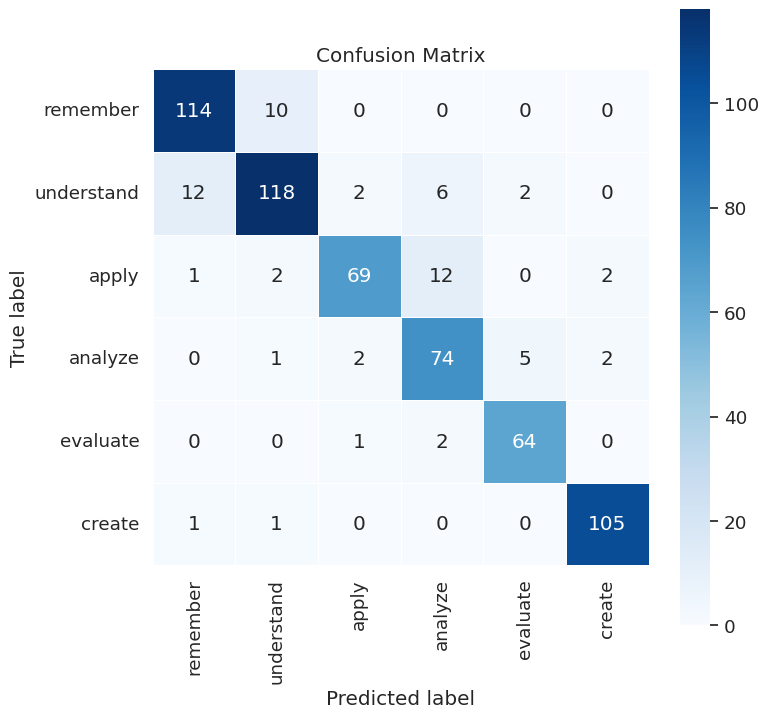

In [150]:
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plot the confusion matrix for multi-class classification.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        classes (list): List of class names.
        title (str): Title of the plot.
        cmap (matplotlib.colors.Colormap): Colormap for the plot.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(len(classes)+2, len(classes)+2))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, linewidths=.5, square=True,
                xticklabels=classes, yticklabels=classes)

    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Example usage:
# Replace y_true and y_pred with your actual and predicted labels

plot_confusion_matrix(true_labels, predicted_labels, classes=['remember', 'understand', 'apply', 'analyze', 'evaluate', 'create'])
